In [9]:
import math
import numpy as np
import pyreadstat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.nonparametric import kernel_regression
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from scipy.stats import norm
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.neighbors import KernelDensity
from scipy.stats import chi2, expon
import time
import random

# Simulation of Chi Squared Data

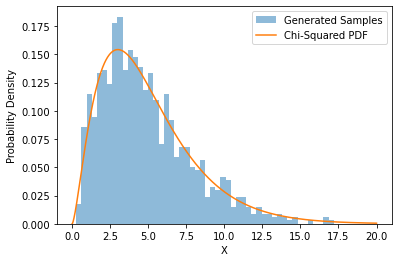

In [223]:
start_time = time.time()

# Define the target distribution as a chi-squared distribution with 5 degrees of freedom
df = 5
target_pdf = chi2(df=df).pdf

# Define the proposal distribution as an exponential distribution with parameter lambda=0.5
proposal_pdf = expon(scale=2).pdf

# Define the constant M such that the proposal distribution is bounded by M times the target distribution
M = 10

# Initialize the array to store the generated samples
samples = []

# Generate the samples using the accept-reject method
while len(samples) < 1000:
    # Generate a sample from the proposal distribution
    x = np.random.exponential(scale=2)
    
    # Calculate the acceptance probability
    p_accept = target_pdf(x) / (M * proposal_pdf(x))
    
    # Generate a uniform random number in [0,1]
    u = np.random.uniform()
    
    # Accept the sample with probability p_accept
    if u < p_accept:
        samples.append(x)

# Plot a histogram of the samples
plt.hist(samples, bins=50, density=True, alpha=0.5, label='Generated Samples')

# Generate x values for the PDF plot
x = np.linspace(0, 20, 1000)

# Calculate the PDF values for the chi-squared distribution with 5 degrees of freedom
pdf_values = chi2(df=df).pdf(x)

# Plot the PDF curve on top of the histogram
plt.plot(x, pdf_values, label='Chi-Squared PDF')

# Set the axis labels and legend
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()

end_time = time.time()

In [224]:
print ("My program took", end_time - start_time, "to run")

My program took 4.2730185985565186 to run


### Thus we have can see that our generated data roughly follows the chi squared distribution with 5 degrees of freedom

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


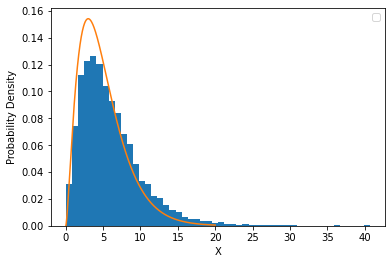

In [227]:
#For generating normal distibution, first we take generate uniform random variable, then take a squared sum of them:
start_time = time.time()
#set degrees of freedom of distribution
k = 5
# Set number of samples to generate
n = 10000

samples = []
while len(samples) <= n:
    
    l = []
    while len(l) <= k:

        # Generate a random number between 0 and 1
        u = random.uniform(0, 1)
        y = random.uniform(0, 1)
        w = random.uniform(0, 1)

        if -2*math.log(y) >= (math.log(u) + 1)**2:
            z = -math.log(u)
        if w >= 0.5:
            x = z
        else:
            x = -z
        l.append(x)

    chi = sum(i*i for i in l)
    samples.append(chi)
    


# Plot the histogram of the samples
plt.hist(samples, bins=50, density=True)

x = np.linspace(0, 20, 10000)

# Calculate the PDF values for the chi-squared distribution with 5 degrees of freedom
pdf_values = chi2.pdf(x, df=5)

# Plot the PDF curve on top of the histogram
plt.plot(x, pdf_values)

# Set the axis labels and legend
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()
end_time = time.time()


In [228]:
print ("My program took", end_time - start_time, "to run")

My program took 0.8211948871612549 to run


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


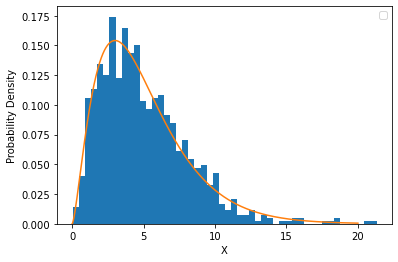

In [229]:
start_time = time.time()

# Generate 1000 samples from a chi-squared distribution with 5 degrees of freedom
samples = np.random.chisquare(df=5, size=1000)

# Plot the histogram of the samples
plt.hist(samples, bins=50, density=True)

x = np.linspace(0, 20, 10000)

# Calculate the PDF values for the chi-squared distribution with 5 degrees of freedom
pdf_values = chi2.pdf(x, df=5)

# Plot the PDF curve on top of the histogram
plt.plot(x, pdf_values)

# Set the axis labels and legend
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()

end_time = time.time()

In [1]:
print ("My program took", end_time - start_time, "to run")

NameError: name 'end_time' is not defined

# Analysis of CNNS Data

## To Do: 1. Clean Data 2. Find variables for regression 3. OLS and KR with weights

In [6]:
df1, meta1 = pyreadstat.read_sav(r"C:\Users\WBFBCP\Downloads\Punjab_cnns.sav")

In [4]:
import pyreadstat

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [11]:
df1.head()

,caseid,state,area,psu_no,psu_no_ov,region,hh_no,int_d,int_m,int_y,q102,q103m,q103y,q104,q111m,q111y,q112,q113y,q113m,q114,q115,q116,q117,q118,q125,q201A,q201B,q201C,q201D,q201E,q201F,q201G,q201H,q201I,q201J,q201X,q201Y,q201o,q301,q302,q303,q304,q305,q305o,q306a,q306b,q306c,q306d,q306e,q306f,q306g,q306h,q306i,q306j,q306k,q306l,q306m,q306n,q306o,q306p,q306q,q901r1,q902r1,q902r2,q903r1,q903r2,q904r1,q904r2,q905r1,q905r2,q906r1,q906r2,height,muac,tsft,ssft,wc,agemons,z_wc,z_tsft,z_ssft,z_muac,@_cbmi,@_zwfa,@_zhfa,@_zbfa,@_fwfa,@_fhfa,@_fbfa,hgbn_alt_unic,crp1_dunic,creat_unic,fer_unic,vtb12c_unic,hydrov_unic,vitaa_unic,zns_unic,rbcf_1unic,glus_unic,hb_a1c_unic,cho_dunic,tri_dunic,dirldl_dunic2,chohdl_dunic,uiod_unic,bp_unic,bp_sys1,bp_dysys1,bp_sys2,bp_dysys2,bp_sys3,bp_dysys3,wi,wi_s,state_weight_survey,state_weight_bio,reg_weight_survey,reg_weight_bio,nat_weight_bio,nat_weight_survey,fasting_status
0,3.100101e+09,3.0,1.0,1.0,131.0,1.0,9.0,7.0,1.0,2018.0,1.0,1.0,2002.0,16.0,98.0,9998.0,41.0,NaN,NaN,1.0,991.0,1.0,1.0,8.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,,2.0,NaN,2.0,2.0,NaN,,7.0,7.0,2.0,5.0,8.0,8.0,7.0,9.0,9.0,9.0,8.0,7.0,7.0,8.0,2.0,8.0,9.0,62.6,176.6,176.6,26.3,26.2,12.0,12.0,8.8,8.8,73.1,73.0,176.600006,26.250000,12.000000,8.8,73.050003,192.0,-0.08,0.727278,0.340923,-0.437960,20.072104,NaN,0.48,-0.17,NaN,0.0,0.0,12.6,-97.0,0.6,105.1,44444.0,9.31,40.6,59.04,343.14,86.0,5.5,154.0,130.0,89.0,46.0,97.36,126/86MM/HG\n122/82MM/HG\n120/82MM/HG,126.0,86.0,122.0,82.0,120.0,82.0,5.0,3.0,1.205748,1.081321,1.294528,0.997249,0.597357,0.772004,YES
1,3.100101e+09,3.0,1.0,1.0,131.0,1.0,10.0,8.0,1.0,2018.0,1.0,8.0,2004.0,13.0,98.0,1985.0,37.0,NaN,NaN,1.0,991.0,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,2.0,NaN,2.0,1.0,5.0,,7.0,7.0,2.0,2.0,2.0,8.0,9.0,9.0,9.0,9.0,1.0,8.0,7.0,9.0,9.0,9.0,9.0,36.5,158.9,159.0,18.4,18.5,3.8,4.0,5.2,5.4,59.2,59.2,158.949997,18.450001,3.900000,5.3,59.200001,161.0,-1.59,-2.172338,-0.431091,-2.245030,14.446805,NaN,-0.02,-2.58,NaN,0.0,0.0,13.6,-97.0,0.6,10.5,184.0,8.94,28.6,64.94,328.25,89.0,5.4,113.0,45.0,55.0,50.0,81.12,116/80MM/HG\n114/78MM/HG\n114/76MM/HG,116.0,80.0,114.0,78.0,114.0,76.0,4.0,2.0,0.767061,0.591207,0.956660,0.633248,0.379319,0.570513,YES
2,3.100103e+09,3.0,1.0,1.0,131.0,1.0,28.0,10.0,1.0,2018.0,1.0,9.0,2005.0,12.0,6.0,1975.0,42.0,NaN,NaN,4.0,991.0,4.0,1.0,10.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,2.0,NaN,2.0,2.0,NaN,,7.0,7.0,2.0,5.0,3.0,8.0,7.0,9.0,9.0,9.0,3.0,7.0,7.0,8.0,8.0,8.0,8.0,37.3,155.2,155.2,16.3,16.4,7.4,7.6,8.0,8.2,51.4,51.5,155.199997,16.350000,7.500000,8.1,51.450001,148.0,-3.34,-0.582833,0.657388,-3.018408,15.485506,NaN,0.54,-1.33,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,322.47,,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,0.767061,0.591207,0.956660,0.633248,0.379319,0.570513,YES
3,3.100104e+09,3.0,1.0,1.0,131.0,1.0,42.0,9.0,1.0,2018.0,2.0,5.0,1998.0,19.0,98.0,1967.0,50.0,NaN,NaN,1.0,991.0,4.0,1.0,5.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,2.0,NaN,2.0,2.0,NaN,,7.0,7.0,3.0,2.0,2.0,8.0,8.0,8.0,9.0,8.0,8.0,8.0,7.0,8.0,8.0,8.0,8.0,56.5,167.1,167.2,24.9,24.9,18.2,18.2,15.0,15.2,69.2,69.3,167.149994,24.900000,18.200001,15.1,69.250000,236.0,-0.94,-0.075629,0.282740,-0.661921,20.222541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,1.205748,NaN,1.294528,NaN,NaN,0.772004,
4,3.100105e+09,3.0,1.0,1.0,131.0,1.0,48.0,7.0,1.0,2018.0,1.0,11.0,2004.0,13.0,98.0,1980.0,37.0,NaN,NaN,4.0,991.0,4.0,1.0,8.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,2.0,NaN,2.0,2.0,NaN,,7.0,7.0,4.0,2.0,8.0,8.0,5.0,9.0,9.0,9.0,8.0,8.0,7.0,8.0,8.0,8.0,9.0,42.1,155.8,155.9,22.8,22.9,6.8,7.0,5.2,5.2,60.1,60.2,155.850006,22.850000,6.900000,5.2,60.150002,158.0,-1.30,-0.688084,-0.486207,-0.287833,17.332788,NaN,-0.19,-0.51,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,0.767061,NaN,0.956660,NaN,NaN,0.57

In [12]:
df1.shape

(994, 121)

In [13]:
null_percentage = (df1.isnull().sum()/994)*100
null_percentage
#Most of the health variables have missing values,we will drop columns that have more than 30 percent observations missing

caseid                  0.000000
state                   0.000000
area                    0.000000
psu_no                  0.000000
psu_no_ov               0.000000
region                  0.000000
hh_no                   0.000000
int_d                   0.000000
int_m                   0.000000
int_y                   0.000000
q102                    0.000000
q103m                   0.000000
q103y                   0.201207
q104                    0.000000
q111m                   0.000000
q111y                   0.000000
q112                    0.000000
q113y                  98.390342
q113m                  98.390342
q114                    0.000000
q115                    0.000000
q116                    0.402414
q117                    0.000000
q118                   32.494970
q125                    0.000000
q201A                   0.000000
q201B                   0.000000
q201C                   0.000000
q201D                   0.000000
q201E                   0.000000
q201F     

In [14]:
col_to_drop = null_percentage[null_percentage>30].keys()

df1 = df1.drop(col_to_drop, axis=1)

In [15]:
df1.shape

(994, 89)

In [16]:
#Now that columns with large amounts of null values,
#we can remove rows will the remaining null values and see if we lose many observations

df1 = df1.dropna()
df1.shape
#Since the loss is not too much, we take it

(868, 89)

In [17]:
null_percentage = (df1.isnull().sum()/994)*100
null_percentage

#We can see that we are now free from null values

caseid                 0.0
state                  0.0
area                   0.0
psu_no                 0.0
psu_no_ov              0.0
region                 0.0
hh_no                  0.0
int_d                  0.0
int_m                  0.0
int_y                  0.0
q102                   0.0
q103m                  0.0
q103y                  0.0
q104                   0.0
q111m                  0.0
q111y                  0.0
q112                   0.0
q114                   0.0
q115                   0.0
q116                   0.0
q117                   0.0
q125                   0.0
q201A                  0.0
q201B                  0.0
q201C                  0.0
q201D                  0.0
q201E                  0.0
q201F                  0.0
q201G                  0.0
q201H                  0.0
q201I                  0.0
q201J                  0.0
q201X                  0.0
q201Y                  0.0
q201o                  0.0
q301                   0.0
q303                   0.0
q

In [47]:
df1.to_csv("punjab_data.csv")

In [49]:
df1.to_excel('punjab_data2.xlsx')

In [18]:
#First, we take out the given by the survey to various observations

weights = df1['state_weight_survey']

In [19]:
weights.shape

(868,)

In [20]:
df1.head()

,caseid,state,area,psu_no,psu_no_ov,region,hh_no,int_d,int_m,int_y,q102,q103m,q103y,q104,q111m,q111y,q112,q114,q115,q116,q117,q125,q201A,q201B,q201C,q201D,q201E,q201F,q201G,q201H,q201I,q201J,q201X,q201Y,q201o,q301,q303,q304,q305o,q306a,q306b,q306c,q306d,q306e,q306f,q306g,q306h,q306i,q306j,q306k,q306l,q306m,q306n,q306o,q306p,q306q,q901r1,q902r1,q902r2,q903r1,q903r2,q904r1,q904r2,q905r1,q905r2,q906r1,q906r2,height,muac,tsft,ssft,wc,agemons,z_wc,z_tsft,z_ssft,z_muac,@_cbmi,@_zhfa,@_zbfa,@_fhfa,@_fbfa,bp_unic,wi,wi_s,state_weight_survey,reg_weight_survey,nat_weight_survey,fasting_status
0,3.100101e+09,3.0,1.0,1.0,131.0,1.0,9.0,7.0,1.0,2018.0,1.0,1.0,2002.0,16.0,98.0,9998.0,41.0,1.0,991.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,,2.0,2.0,2.0,,7.0,7.0,2.0,5.0,8.0,8.0,7.0,9.0,9.0,9.0,8.0,7.0,7.0,8.0,2.0,8.0,9.0,62.6,176.6,176.6,26.3,26.2,12.0,12.0,8.8,8.8,73.1,73.0,176.600006,26.250000,12.0,8.8,73.050003,192.0,-0.08,0.727278,0.340923,-0.437960,20.072104,0.48,-0.17,0.0,0.0,126/86MM/HG\n122/82MM/HG\n120/82MM/HG,5.0,3.0,1.205748,1.294528,0.772004,YES
1,3.100101e+09,3.0,1.0,1.0,131.0,1.0,10.0,8.0,1.0,2018.0,1.0,8.0,2004.0,13.0,98.0,1985.0,37.0,1.0,991.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,2.0,2.0,1.0,,7.0,7.0,2.0,2.0,2.0,8.0,9.0,9.0,9.0,9.0,1.0,8.0,7.0,9.0,9.0,9.0,9.0,36.5,158.9,159.0,18.4,18.5,3.8,4.0,5.2,5.4,59.2,59.2,158.949997,18.450001,3.9,5.3,59.200001,161.0,-1.59,-2.172338,-0.431091,-2.245030,14.446805,-0.02,-2.58,0.0,0.0,116/80MM/HG\n114/78MM/HG\n114/76MM/HG,4.0,2.0,0.767061,0.956660,0.570513,YES
2,3.100103e+09,3.0,1.0,1.0,131.0,1.0,28.0,10.0,1.0,2018.0,1.0,9.0,2005.0,12.0,6.0,1975.0,42.0,4.0,991.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,2.0,2.0,2.0,,7.0,7.0,2.0,5.0,3.0,8.0,7.0,9.0,9.0,9.0,3.0,7.0,7.0,8.0,8.0,8.0,8.0,37.3,155.2,155.2,16.3,16.4,7.4,7.6,8.0,8.2,51.4,51.5,155.199997,16.350000,7.5,8.1,51.450001,148.0,-3.34,-0.582833,0.657388,-3.018408,15.485506,0.54,-1.33,0.0,0.0,,5.0,5.0,0.767061,0.956660,0.570513,YES
4,3.100105e+09,3.0,1.0,1.0,131.0,1.0,48.0,7.0,1.0,2018.0,1.0,11.0,2004.0,13.0,98.0,1980.0,37.0,4.0,991.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,2.0,2.0,2.0,,7.0,7.0,4.0,2.0,8.0,8.0,5.0,9.0,9.0,9.0,8.0,8.0,7.0,8.0,8.0,8.0,9.0,42.1,155.8,155.9,22.8,22.9,6.8,7.0,5.2,5.2,60.1,60.2,155.850006,22.850000,6.9,5.2,60.150002,158.0,-1.30,-0.688084,-0.486207,-0.287833,17.332788,-0.19,-0.51,0.0,0.0,,4.0,3.0,0.767061,0.956660,0.570513,
5,3.100106e+09,3.0,1.0,1.0,131.0,1.0,57.0,7.0,1.0,2018.0,2.0,10.0,2002.0,15.0,7.0,1966.0,51.0,1.0,991.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,2.0,2.0,2.0,,7.0,1.0,2.0,5.0,9.0,8.0,8.0,9.0,9.0,9.0,9.0,7.0,7.0,8.0,8.0,8.0,8.0,35.5,157.9,157.8,17.9,18.0,8.6,8.4,7.6,7.4,56.2,56.3,157.850006,17.950001,8.5,7.5,56.250000,183.0,-2.40,-1.413070,-0.750151,-3.516047,14.247516,-0.60,-3.12,0.0,0.0,11/73MM/HG<BR>107/74MM/HG<BR>108/72MM/HG,5.0,3.0,1.205748,1.294528,0.772004,YES


In [21]:
#Let us try to explain height of children. We thus look at the correlations of height with other variables.  

drop_cols_corr = df1.corrwith(df1['height'])[abs(df1.corrwith(df1['height'])) < 0.2].keys()

#we will drop columns with lass than 0.2 correlation

df2 = df1.drop(drop_cols_corr, axis = 1)


C:\Users\WBFBCP\AppData\Local\Temp\ipykernel_4444\1129459752.py:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  drop_cols_corr = df1.corrwith(df1['height'])[abs(df1.corrwith(df1['height'])) < 0.2].keys()
C:\Users\WBFBCP\AppData\Local\Temp\ipykernel_4444\1129459752.py:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  drop_cols_corr = df1.corrwith(df1['height'])[abs(df1.corrwith(df1['height'])) < 0.2].keys()


In [22]:
df2.corrwith(df2['height'])

C:\Users\WBFBCP\AppData\Local\Temp\ipykernel_4444\3935206697.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2.corrwith(df2['height'])


state           NaN
region          NaN
q102      -0.283016
q104       0.695866
q201I           NaN
q201X           NaN
q201Y           NaN
q304       0.208132
q901r1     0.759446
q902r1     0.999998
q902r2     0.999998
q903r1     0.597965
q903r2     0.598526
q905r1     0.241243
q905r2     0.240448
q906r1     0.529728
q906r2     0.529938
height     1.000000
muac       0.598257
ssft       0.240878
wc         0.529835
agemons    0.696540
z_wc       0.243727
z_tsft     0.278983
@_cbmi     0.283546
@_zhfa     0.543379
@_fbfa          NaN
wi_s       0.202802
dtype: float64

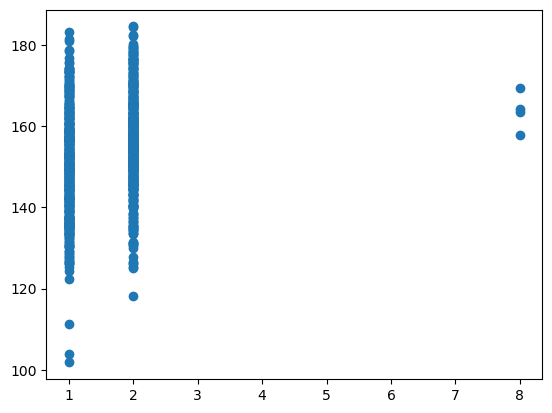

In [23]:
#We can see that there is some correlation between consumption of deworming tablets and height, we can explore this

plt.scatter(x = 'q304', y = 'height', data = df2)

#Correlation is not strong, plus it is opposite to what we expected: not having deworming tablets gives slightly higher height

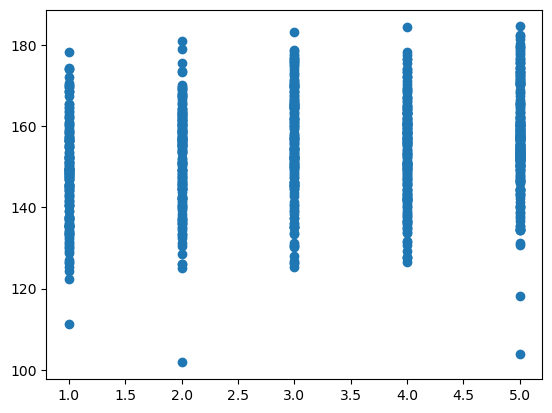

In [24]:
plt.scatter(x = 'wi_s', y = 'height', data = df2)

#We can see that as wealth index increases, height is also increasing

<Axes: xlabel='wi_s', ylabel='height'>

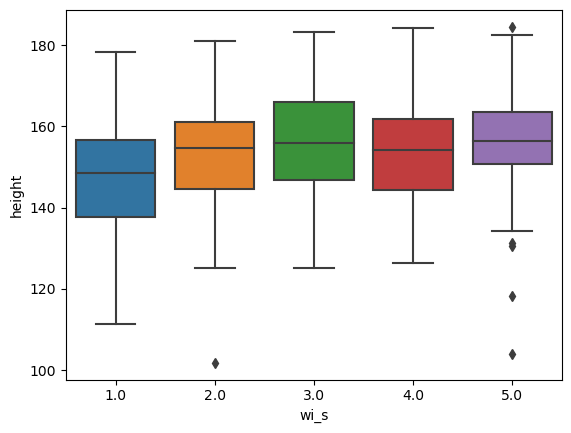

In [25]:
sns.boxplot(x = 'wi_s', y= 'height', data = df2)

#The effect is small but is reiterated by boxplots

In [26]:
#We can do a linear regression and look at the results
X = df2[['wi_s']]
y = df2['height']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(694, 1)
(174, 1)
(694,)
(174,)


In [27]:
model = LinearRegression()

In [28]:
model.fit(X_train, y_train)

LinearRegression()

In [29]:
# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Get the R-squared value
r_squared = model.score(X_train, y_train)

print("Coefficients: ", coefficients)
print("Intercept: ", intercept)
print("R-squared: ", r_squared)

#We can see that the model is not a good fit

Coefficients:  [1.80248228]
Intercept:  147.6647279074633
R-squared:  0.04155088018332842


In [30]:
# Make predictions on test data
y_pred = model.predict(X_test)

# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print("Mean squared error: ", mse)
print("R-squared: ", r_squared)

#Once again it is reiterated that this is a poor fit

Mean squared error:  162.4936738835961
R-squared:  0.0262927014978952


<Axes: xlabel='muac', ylabel='height'>

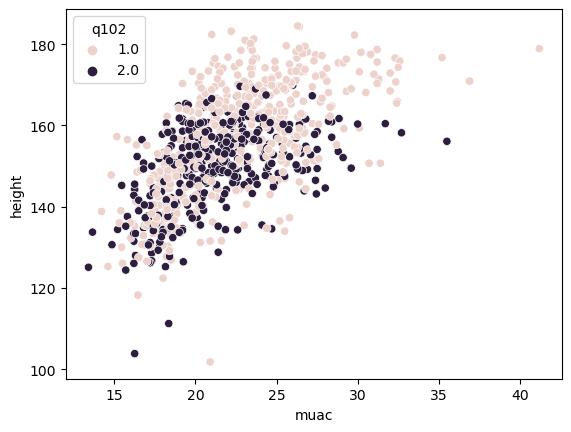

In [31]:
#Let us use mean upper arm circumference to explain height

sns.scatterplot(x = 'muac', y = 'height', data = df2, hue = 'q102')

In [32]:
#Here we use wealth to explain body mass index

df2.corrwith(df2['@_cbmi'])

C:\Users\WBFBCP\AppData\Local\Temp\ipykernel_4444\4103520586.py:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2.corrwith(df2['@_cbmi'])


state           NaN
region          NaN
q102      -0.079255
q104       0.380278
q201I           NaN
q201X           NaN
q201Y           NaN
q304       0.170631
q901r1     0.821807
q902r1     0.283501
q902r2     0.283589
q903r1     0.774184
q903r2     0.775166
q905r1     0.680591
q905r2     0.681973
q906r1     0.725176
q906r2     0.725376
height     0.283546
muac       0.774690
ssft       0.681373
wc         0.725278
agemons    0.381912
z_wc       0.502710
z_tsft     0.618853
@_cbmi     1.000000
@_zhfa    -0.035720
@_fbfa          NaN
wi_s       0.244893
dtype: float64

In [33]:
#We can do a linear regression and look at the results
X = df2[['wi_s']]
y = df2['@_cbmi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(694, 1)
(174, 1)
(694,)
(174,)


In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [35]:
# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Get the R-squared value
r_squared = model.score(X_train, y_train)

print("Coefficients: ", coefficients)
print("Intercept: ", intercept)
print("R-squared: ", r_squared)

#We can see that the model is not a good fit

Coefficients:  [0.61989997]
Intercept:  16.268982630956426
R-squared:  0.05981920054258716


<Axes: xlabel='wi_s', ylabel='@_cbmi'>

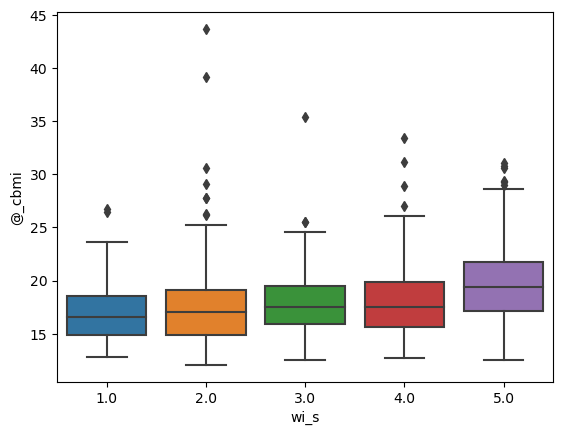

In [36]:
sns.boxplot(x = 'wi_s', y = '@_cbmi', data = df2)

<Axes: xlabel='@_cbmi', ylabel='muac'>

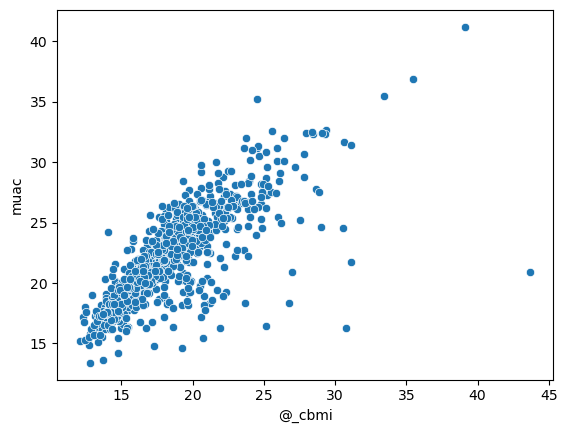

In [37]:
sns.scatterplot(x = '@_cbmi', y = 'muac', data = df2)

### Explaining BMI with mid upper arm circumference and waist circumference

# OLS (Statsmodels)

In [38]:
#We can do a linear regression and look at the results 
X_and_weights = df1[['muac', 'wc', 'state_weight_survey']]
y = df1['@_cbmi']
X_train_weights, X_test_weights, y_train, y_test = train_test_split(X_and_weights, y, test_size=0.2, random_state=101)

X_train = X_train_weights[['muac', 'wc']]
X_test = X_test_weights[['muac', 'wc']]
print(X_train_weights.shape)
print(X_test_weights.shape)
print(y_train.shape)
print(y_test.shape)

(694, 3)
(174, 3)
(694,)
(174,)


In [39]:
X_sm = sm.add_constant(X_train) # Add a constant term to the predictor variable
X_test_sm = sm.add_constant(X_test) # Add a constant term to the predictor variable
model_sm = sm.OLS(y_train, X_sm) # Fit the model
results = model_sm.fit() # Get the regression coefficients

In [40]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 @_cbmi   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     541.0
Date:                Sun, 21 May 2023   Prob (F-statistic):          4.14e-142
Time:                        15:49:11   Log-Likelihood:                -1557.2
No. Observations:                 694   AIC:                             3120.
Df Residuals:                     691   BIC:                             3134.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1476      0.615     -0.240      0.8

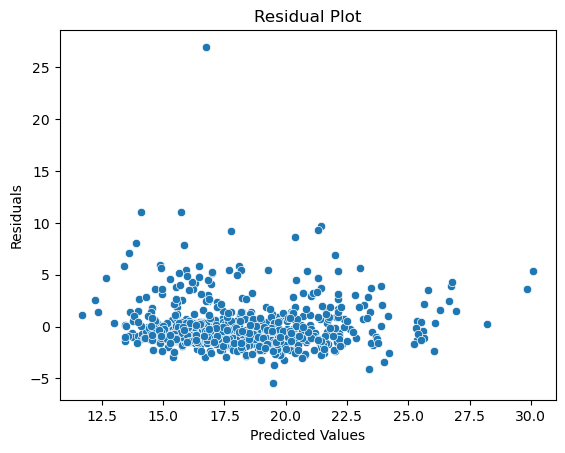

In [51]:
#In sample prediction and heteroskedasticity

y_pred = results.predict(X_sm)

# Calculate residuals
residuals = y_train - y_pred

# Plot residuals
sns.scatterplot(x = y_pred,y =  residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [52]:
# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_sm)

print("Breusch-Pagan test statistic: ", bp_test[0])
print("Breusch-Pagan p-value: ", bp_test[1])

Breusch-Pagan test statistic:  0.4266771712054984
Breusch-Pagan p-value:  0.8078825535020205


### Thus we cannot reject the null hypothesis of heteroskedasticty

In [53]:
#Out of sample performance of this model

y_pred = results.predict(X_test_sm)

# Calculate the R-squared on the test data
r2 = r2_score(y_test, y_pred)

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_test, y_pred)

print("R-squared on test data: ", r2)
print("MSE on test data: ", mse)

R-squared on test data:  0.6325649357707679
MSE on test data:  4.6866711693704755


### Similar performance on out of sample 

### We do OLS now without intercept

In [54]:
model_sm = sm.OLS(y_train, X_train) # Fit the model
results = model_sm.fit() # Get the regression coefficients

In [55]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 @_cbmi   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          2.261e+04
Date:                Sun, 21 May 2023   Prob (F-statistic):                        0.00
Time:                        16:52:03   Log-Likelihood:                         -1557.3
No. Observations:                 694   AIC:                                      3119.
Df Residuals:                     692   BIC:                                      3128.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### We can note that OLS produces much better results without intercept and overall it is a very good fit

In [56]:
#Out of sample prediction of the model without intercept

y_pred = results.predict(X_test)

# Calculate the R-squared on the test data
r2 = r2_score(y_test, y_pred)

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_test, y_pred)

print("R-squared on test data: ", r2)
print("MSE on test data: ", mse)

R-squared on test data:  0.6330997015410315
MSE on test data:  4.679850178229857


### Out of sample prediction is similar to previous model

# Kernel Regression

In [57]:
#We do a univariate kernal regression using BMI and muac
#First we will do this using unweighted data

X = df1[['muac']]
y = df1['@_cbmi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(694, 1)
(174, 1)
(694,)
(174,)


In [58]:
model_kr = kernel_regression.KernelReg(endog=y_train, exog=X_train , var_type='c',reg_type='lc', bw= 'cw_ls')

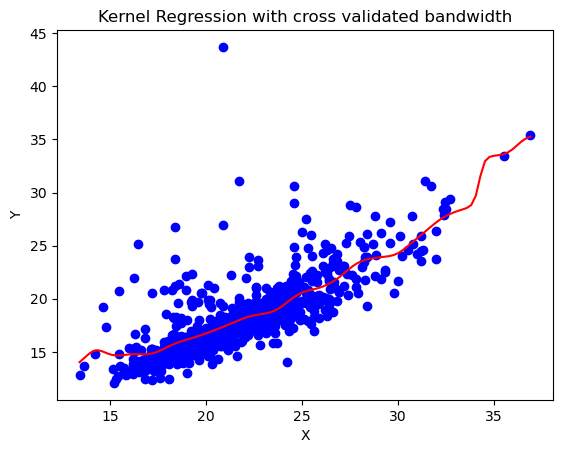

In [59]:
# generate predicted values for plotting
x_vals = np.linspace(X_train.min(), X_train.max(), num=100).reshape(-1, 1)
y_pred, _ = model_kr.fit(x_vals)

# plot the original data points and kernel regression line
plt.scatter(X_train, y_train, color='blue')
plt.plot(x_vals, y_pred, color='red')

# add plot titles and labels
plt.title('Kernel Regression with cross validated bandwidth')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [60]:
#Let us look at the in sample performance of kernel regression:

y_pred, _ = model_kr.fit(X_train)

# Calculate the R-squared on the test data
r2 = r2_score(y_train, y_pred)

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_train, y_pred)

print("R-squared on test data: ", r2)
print("MSE on test data: ", mse)

R-squared on test data:  0.6194635919359368
MSE on test data:  5.083232373331261


In [61]:
#let us look at out of sample performance of kernel regression

y_pred, _ = model_kr.fit(X_test)

# Calculate the R-squared on the test data
r2 = r2_score(y_test, y_pred)

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_test, y_pred)

print("R-squared on test data: ", r2)
print("MSE on test data: ", mse)

R-squared on test data:  0.6122091631975166
MSE on test data:  4.946311094181247


## Multivariate Kernel Regression

In [62]:
X = df1[['muac', 'wc']]
y = df1['@_cbmi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(694, 2)
(174, 2)
(694,)
(174,)


In [63]:
model_kr = kernel_regression.KernelReg(endog=y_train, exog=X_train , var_type='cc',reg_type='lc', bw= 'cw_ls')

In [64]:
#Let us look at the in sample performance of kernel regression:

y_pred, _ = model_kr.fit(X_train)

# Calculate the R-squared on the test data
r2 = r2_score(y_train, y_pred)

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_train, y_pred)

print("R-squared on test data: ", r2)
print("MSE on test data: ", mse)


R-squared on test data:  0.7252338370829094
MSE on test data:  3.6703459244326293


### Performs better in sample than OLS

In [65]:
#let us look at out of sample performance of kernel regression

y_pred, _ = model_kr.fit(X_test)

# Calculate the R-squared on the test data
r2 = r2_score(y_test, y_pred)

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_test, y_pred)

print("R-squared on test data: ", r2)
print("MSE on test data: ", mse)

R-squared on test data:  0.6559858751072272
MSE on test data:  4.387934734463222


### Out of sample performance is not that good but still better than OLS (might be indicative of overfitting)

### Weighted Kernel Regression

In [66]:
df3 = df1.copy()

df3['muac'] = np.multiply(df1['muac'], df1['state_weight_survey'])
df3['wc'] = np.multiply(df1['wc'], df1['state_weight_survey'])
df3['@_cbmi'] = np.multiply(df1['@_cbmi'], df1['state_weight_survey'])

In [67]:
X = df3[['muac', 'wc']]
y = df3['@_cbmi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(694, 2)
(174, 2)
(694,)
(174,)


In [68]:
model_kr = kernel_regression.KernelReg(endog=y_train, exog=X_train , var_type='cc',reg_type='lc', bw= 'cw_ls')

In [69]:
#Let us look at the in sample performance of kernel regression:

y_pred, _ = model_kr.fit(X_train)

# Calculate the R-squared on the test data
r2 = r2_score(y_train, y_pred)

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_train, y_pred)

print("R-squared on test data: ", r2)
print("MSE on test data: ", mse)


R-squared on test data:  0.9926538628571903
MSE on test data:  2.173701911331332


In [70]:
#let us look at out of sample performance of kernel regression

y_pred, _ = model_kr.fit(X_test)

C:\Users\WBFBCP\anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)
C:\Users\WBFBCP\anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
C:\Users\WBFBCP\anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x


In [71]:
#Had to remove last obervation due to NaN value

# Calculate the R-squared on the test data
r2 = r2_score(y_test[:-1], y_pred[:-1])

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_test[:-1], y_pred[:-1])

print("R-squared on test data: ", r2)
print("MSE on test data: ", mse)

R-squared on test data:  0.9822692771457725
MSE on test data:  6.932785505546248


### Overall, multivariate weighted kernel seems to be a very good fit

# Kernel Density Estimation

### We will do the estimation for height

In [72]:
height = df1['height']

<Axes: xlabel='height', ylabel='Count'>

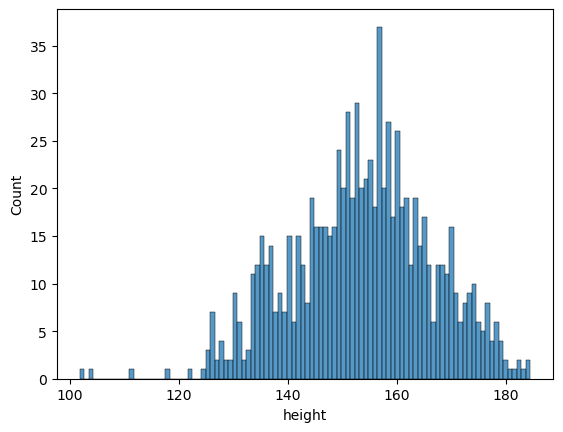

In [73]:
sns.histplot(height, bins = 100)

In [74]:
n = len(height)
mu, sigma = norm.fit(height)
plugin_bandwidth = 1.06*sigma*n**(-1/5)

In [75]:
# Create the kernel density estimate
kde_plugin = gaussian_kde(height, bw_method= plugin_bandwidth)

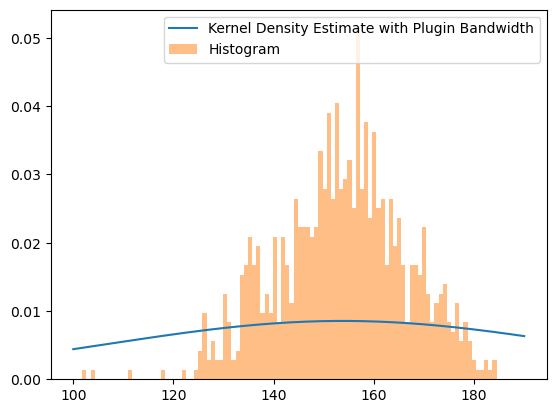

In [76]:
# Evaluate the kernel density estimate at various points
x_eval = np.linspace(100, 190, num=1000)
y_eval = kde_plugin(x_eval)

# Plot the results
plt.plot(x_eval, y_eval, label='Kernel Density Estimate with Plugin Bandwidth')
plt.hist(height, bins=100, density=True, alpha=0.5, label='Histogram')
plt.legend()
plt.show()

### Scott's rule

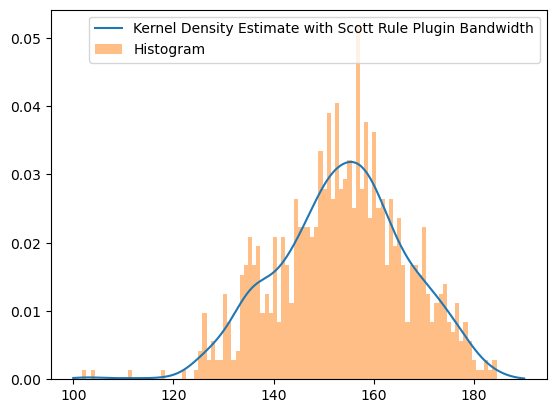

In [77]:
# Create the kernel density estimate
kde = gaussian_kde(height)
# Evaluate the kernel density estimate at various points
x_eval = np.linspace(100, 190, num=1000)
y_eval = kde(x_eval)

# Plot the results
plt.plot(x_eval, y_eval, label='Kernel Density Estimate with Scott Rule Plugin Bandwidth')
plt.hist(height, bins=100, density=True, alpha=0.5, label='Histogram')
plt.legend()
plt.show()

### Silverman's Rule

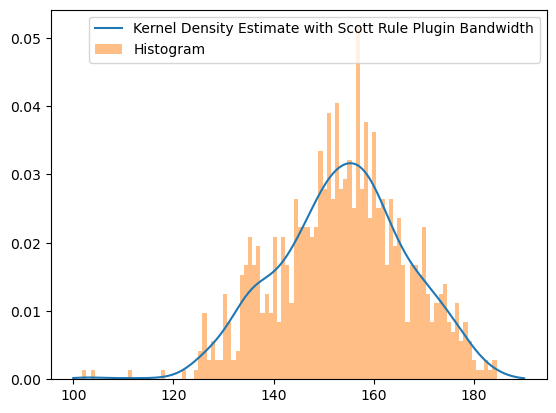

In [78]:
# Create the kernel density estimate
kde = gaussian_kde(height, bw_method='silverman')
# Evaluate the kernel density estimate at various points
x_eval = np.linspace(100, 190, num=1000)
y_eval = kde(x_eval)

# Plot the results
plt.plot(x_eval, y_eval, label='Kernel Density Estimate with Scott Rule Plugin Bandwidth')
plt.hist(height, bins=100, density=True, alpha=0.5, label='Histogram')
plt.legend()
plt.show()

### Epanechnikov Kernel

In [79]:
kde_epa = KernelDensity(bandwidth=plugin_bandwidth, kernel='epanechnikov')

In [80]:
kde_epa.fit(height[:, None])

C:\Users\WBFBCP\AppData\Local\Temp\ipykernel_4444\1312876363.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde_epa.fit(height[:, None])


KernelDensity(bandwidth=3.505952660511444, kernel='epanechnikov')

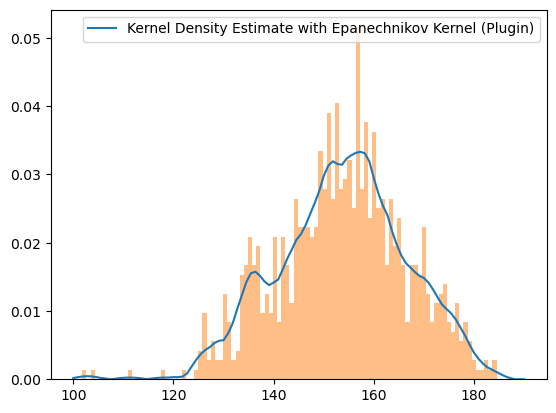

In [81]:
# Evaluate the KDE at some points
points = np.linspace(100, 190, 100).reshape(-1, 1)
density = np.exp(kde_epa.score_samples(points))

# Plot the KDE
plt.plot(points, density, label='Kernel Density Estimate with Epanechnikov Kernel (Plugin)')
plt.legend()
plt.hist(height, bins=100, density=True, alpha=0.5, label='Histogram')
plt.show()

### Epanechnikov Kernel and Scott Rule

In [82]:
scott_bandwidth = n**(-1./(4+1))

In [83]:
kde_epa = KernelDensity(bandwidth=scott_bandwidth, kernel='epanechnikov')

In [84]:
kde_epa.fit(height[:, None])

C:\Users\WBFBCP\AppData\Local\Temp\ipykernel_4444\1312876363.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde_epa.fit(height[:, None])


KernelDensity(bandwidth=0.25840210962280624, kernel='epanechnikov')

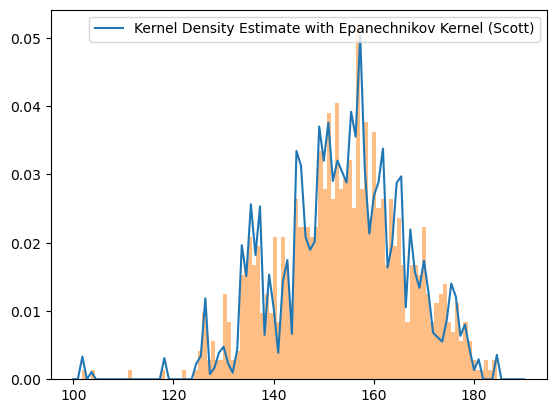

In [85]:
# Evaluate the KDE at some points
points = np.linspace(100, 190, 100).reshape(-1, 1)
density = np.exp(kde_epa.score_samples(points))

# Plot the KDE
plt.plot(points, density, label='Kernel Density Estimate with Epanechnikov Kernel (Scott)')
plt.legend()
plt.hist(height, bins=100, density=True, alpha=0.5, label='Histogram')
plt.show()